In [186]:
import os
import sys
import pathlib
import pickle

from scapy.all import * 
import numpy as np
import matplotlib.pyplot as plt
import pandas
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tensorboardX import SummaryWriter

from logger import logger
from dataset import MTU_LENGTH

dirname = pathlib.Path.cwd()
plt.set_loglevel('info')

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
else:
    torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


using cuda: Quadro RTX 4000


In [187]:
from collections import Counter
from sklearn.utils import resample

class PcapDataset(Dataset):

    def __init__(self, vpn=False, type=False, app=False, test=False) -> None:
        super().__init__()

        self.vpn = vpn
        self.type = type
        self.app = app
        self.test = test
        with open("data/filtered_packets_5000.pickle", 'rb') as file:
#          with open("test.pickle", 'rb') as file:
#         with open("data/packets.pickle", 'rb') as file:
            data = file.read()
            self.packets = pickle.loads(data)
#         self.packets = self.balance_classes(self.packets)
#             print(len(self.packets))
#             print(data)
#             print(self.packets)

    def __len__(self):
        return len(self.packets)
    
#     def balance_classes(self, packets):
#         class_counts = self.get_class_counts(packets)
#         max_count = 4500
#         balanced_packets = []
#         for cls, count in class_counts.items():
#             cls_packets = [p for p in packets if self.get_label(p) == cls]
#             if count > max_count:
#                 cls_packets = resample(cls_packets, replace=False, n_samples=max_count, random_state=42)
#             else:
#                 cls_packets = resample(cls_packets, replace=True, n_samples=max_count, random_state=42)
#             balanced_packets.extend(cls_packets)

#         return balanced_packets
    
#     def get_class_counts(self, packets):
#         counts = Counter([self.get_label(p) for p in packets])
#         return counts
    
    def get_label(self, packet):
        vpn, ty, app, content = packet
        if self.vpn:
            return vpn
        elif self.type:
            return ty - 1
        elif self.app:
            return app - 1
    
    def get_type_count(self):
        if self.vpn:
            return 2
        if self.type:
            return 6
        if self.app:
            return 16
        raise Exception("unknown classify type")

    def __getitem__(self, index):
        if index >= len(self.packets):
            raise StopIteration
        
#         print(index)
        row = self.packets[index]
        
        vpn, ty, app, content = row

        target = torch.zeros(self.get_type_count())

        if self.vpn:
            label = vpn
        elif self.type:
            label = ty - 1
        elif self.app:
            label = app - 1

        target[label] = 1.0

        if len(content) < MTU_LENGTH:
            content += b'\0' * (MTU_LENGTH - len(content))

        content = content[:MTU_LENGTH]

        assert(len(content) == MTU_LENGTH)

        data = np.frombuffer(content, dtype=np.uint8, count=MTU_LENGTH)

        # image = torch.tensor(data.reshape(32, 32).copy()) / 255.0
        image = torch.tensor(data.copy()) / 255.0
        # image = image.view(1, 32, 32)
        image = image.view(1, MTU_LENGTH)

        return label, image, target


In [188]:

class Classifier(nn.Module):

    def __init__(self, type_count):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=1),
            nn.LeakyReLU(0.02, inplace=True),
            # # nn.ReLU(inplace=True),
            # nn.BatchNorm2d(32),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(32, 128, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02, inplace=True),
            # # nn.ReLU(inplace=True),
            # # nn.BatchNorm2d(64),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(128, 64, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02, inplace=True),
            # # nn.ReLU(inplace=True),
            # # nn.BatchNorm2d(64),

            nn.Flatten(),

            # nn.LazyLinear(256),
            # # # nn.Dropout(p=0.05),
            # nn.LeakyReLU(0.02, inplace=True),

            # # nn.LazyLinear(128),
            # # nn.LeakyReLU(0.02, inplace=True),

            nn.LazyLinear(64),
            # # nn.Dropout(p=0.05),
            nn.LeakyReLU(0.02, inplace=True),
            # nn.ReLU(inplace=True),

            nn.LazyLinear(type_count),
            # # nn.Sigmoid(),
            # # nn.LeakyReLU(0.02, inplace=True),
        )

        # self.loss_function = nn.MSELoss()
        self.loss_function = nn.CrossEntropyLoss()

        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.right = 0
        self.total = 0

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, label, inputs, targets):
    # 设置学习率调度器，每5个epochs将学习率乘以0.5
        # scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
        outputs = self.forward(inputs)

        loss = self.loss_function(outputs, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # scheduler.step()
        predicted = torch.max(outputs.data, 1)[1]

        self.right += (predicted == label).sum()
        self.total += len(label)

        return loss


In [189]:
kwargs = {
    'vpn': False,
    'type': False,
    'app': True,
}

epoch = 64
test_percent = 0.05

writer = SummaryWriter()

dataset = PcapDataset(**kwargs)
c = Classifier(dataset.get_type_count())

total_count = len(dataset)
test_count = int(total_count * test_percent)
train_count = total_count - test_count

# print(dataset[0])
label, image, target = dataset[0]
print(image.device, target.device)

output = c.forward(image.view(1, 1, MTU_LENGTH))
print(output.shape)

trainset, testset = random_split(
    dataset,
    [train_count, test_count],
    torch.Generator(device=device))
#读取训练、测试集
# with open('train.pickle', 'rb') as f:
#     trainset = pickle.load(f)
    
# with open('test.pickle', 'rb') as f:
#     testset = pickle.load(f)

loader = DataLoader(
    dataset=trainset,
    batch_size=512,
    shuffle=True,
    generator=torch.Generator(device=device),
    drop_last=True,
)

for var in range(epoch):

    tq = tqdm(loader)

    c.total = 0
    c.right = 0
    for label, image, target in tq:
        loss = c.train(label, image, target)
        acc = c.right / c.total

        writer.add_scalar("loss", loss.item())
        writer.add_scalar("acc", acc)

        tq.set_postfix(epoch=f"{var}", acc='%.6f' % acc)

    tq.close()

cuda:0 cuda:0
torch.Size([1, 16])


  5%|▍         | 40/802 [00:02<00:52, 14.65it/s, acc=0.141309, epoch=0]


KeyboardInterrupt: 

In [205]:
#保存训练测试集
# with open('train1.pickle', 'wb') as f:
#     f.write(pickle.dumps(trainset))
with open('test.pickle','wb') as f:
    f.write(pickle.dumps(testset))

In [244]:
#加载训练好的模型
with open('model_5000_processed.pkl', 'rb') as f:
    c = pickle.load(f)

dataset = PcapDataset(**kwargs)
total_count = len(dataset)
test_count = int(total_count * test_percent)
train_count = total_count - test_count

# print(dataset[0])
label, image, target = dataset[0]
print(image.device, target.device)

output = c.forward(image.view(1, 1, MTU_LENGTH))
print(output.shape)

# trainset, testset = random_split(
#     dataset,
#     [train_count, test_count],
#     torch.Generator(device=device))

cuda:0 cuda:0
torch.Size([1, 16])


In [246]:
# 测试数据
total = 0
right = 0
with open('test.pickle', 'rb') as f:
    testset = pickle.load(f)

# 初始化数据集，设置balance=True以进行重采样

tq = tqdm(testset)
# tq = tqdm(dataset)

rights = np.zeros(dataset.get_type_count(), dtype=np.float32)
totals = np.zeros(dataset.get_type_count(), dtype=np.float32)

for label, image, target in tq:
    outputs = c.forward(image.view(1, 1, MTU_LENGTH))
    total += 1
    totals[label] += 1
    if outputs.argmax() == label:
        right += 1
        rights[label] += 1

    writer.add_scalar("tacc", right / total)
    tq.set_postfix(acc='%.6f' % (right / total))

tq.close()

print(right, total, right / total)

print(totals)
print(rights)
print(rights / totals)


  2%|▏         | 357/20963 [00:01<01:13, 281.60it/s, acc=0.974860]


KeyboardInterrupt: 

In [253]:
import pickle
import numpy as np
import torch
from tqdm import tqdm


with open('test.pickle', 'rb') as f:
    testset = pickle.load(f)


# 初始化数据集
# test_dataset = PcapDataset(vpn=True, test=True, balance=True)
# test_dataset.packets = testset

# 使用tqdm进行进度条显示
tq = tqdm(testset)

# 初始化计数器
total = 0
right = 0

true_positives = np.zeros(dataset.get_type_count(), dtype=np.float32)
predicted_positives = np.zeros(dataset.get_type_count(), dtype=np.float32)
actual_positives = np.zeros(dataset.get_type_count(), dtype=np.float32)

# 遍历测试数据集
for label, image, target in tq:
    outputs = c.forward(image.view(1, 1, MTU_LENGTH))
    total += 1
    totals[label] += 1
    predicted_label = outputs.argmax().item()
    predicted_positives[predicted_label] += 1
    actual_positives[label] += 1
    
    if predicted_label == label:
        right += 1
        rights[label] += 1
        true_positives[label] += 1

    writer.add_scalar("tacc", right / total)
    tq.set_postfix(acc='%.6f' % (right / total))

tq.close()

# 计算查全率（Recall）和查准率（Precision）
recall = true_positives / actual_positives
precision = true_positives / predicted_positives

# 打印结果
print("Overall Accuracy:", right / total)
print("Totals:", totals)
print("Rights:", rights)
print("Recall per class:", recall)
print("Precision per class:", precision)

label = [ "aim", "email", "facebook", "ftp", "gmail", "hangouts", "icq", "netflix",
    "scp", "sftp", "skype", "spotify", "vimeo", "voipbuster", "youtube", "bittorrent"]
for i in range(dataset.get_type_count()):
    print(label[i]+f": Recall = {recall[i]:.6f}, Precision = {precision[i]:.6f}")


100%|██████████| 16425/16425 [00:56<00:00, 289.41it/s, acc=0.965723]

Overall Accuracy: 0.9657229832572298
Totals: [  744.  3418.  9611.  4065.  1265. 10232.  1702.  2700.  5022.  6067.
 15722.  2397.  3562.  4603.  5281.   688.]
Rights: [  484.  3007.  9234.  4049.  1206.  9828.  1507.  2697.  4787.  6043.
 15277.  2334.  3458.  4567.  5242.   688.]
Recall per class: [0.65822786 0.8786611  0.96135265 0.99654377 0.95255476 0.96082
 0.89196676 1.         0.95042896 0.9945227  0.97311026 0.9696395
 0.973262   0.9907975  0.99390775 1.        ]
Precision per class: [0.7878788  0.9388972  0.9268747  0.99425286 0.96309966 0.9813867
 0.98170733 0.9876543  0.997      0.98910505 0.937536   0.97333336
 0.9931787  0.995889   0.9896014  1.        ]
aim: Recall = 0.658228, Precision = 0.787879
email: Recall = 0.878661, Precision = 0.938897
facebook: Recall = 0.961353, Precision = 0.926875
ftp: Recall = 0.996544, Precision = 0.994253
gmail: Recall = 0.952555, Precision = 0.963100
hangouts: Recall = 0.960820, Precision = 0.981387
icq: Recall = 0.891967, Precision = 0.9

In [166]:
#保存模型
with open('model_5000_processed1.pkl', 'wb') as f:
    pickle.dump(c, f)

In [ ]:
#导出图像文件
import matplotlib.pyplot as plt
import torch
import numpy as np



def save_image_as_file(image_tensor, file_name):
    # 将 tensor 转换为 numpy 数组
    image_np = image_tensor.cpu().numpy()

    # 如果需要将其变为 2D 图像，可以取消注释下面的代码
    image_np = image_np.reshape(32, 32)

    # 创建图像并保存
    plt.figure(figsize=(5, 5))
    plt.imshow(image_np, cmap='gray', aspect='auto')  # 如果是 1D 可视化，保持 'aspect='auto''
    plt.title('网络流量数据可视化')
    plt.colorbar()
    plt.savefig(file_name)
    plt.close()
    
    
# 示例用法
label, image, target = dataset[0]
x=0
for i in image:
    x+=1
    print(x)
    save_image_as_file(i,str(x)+".png")


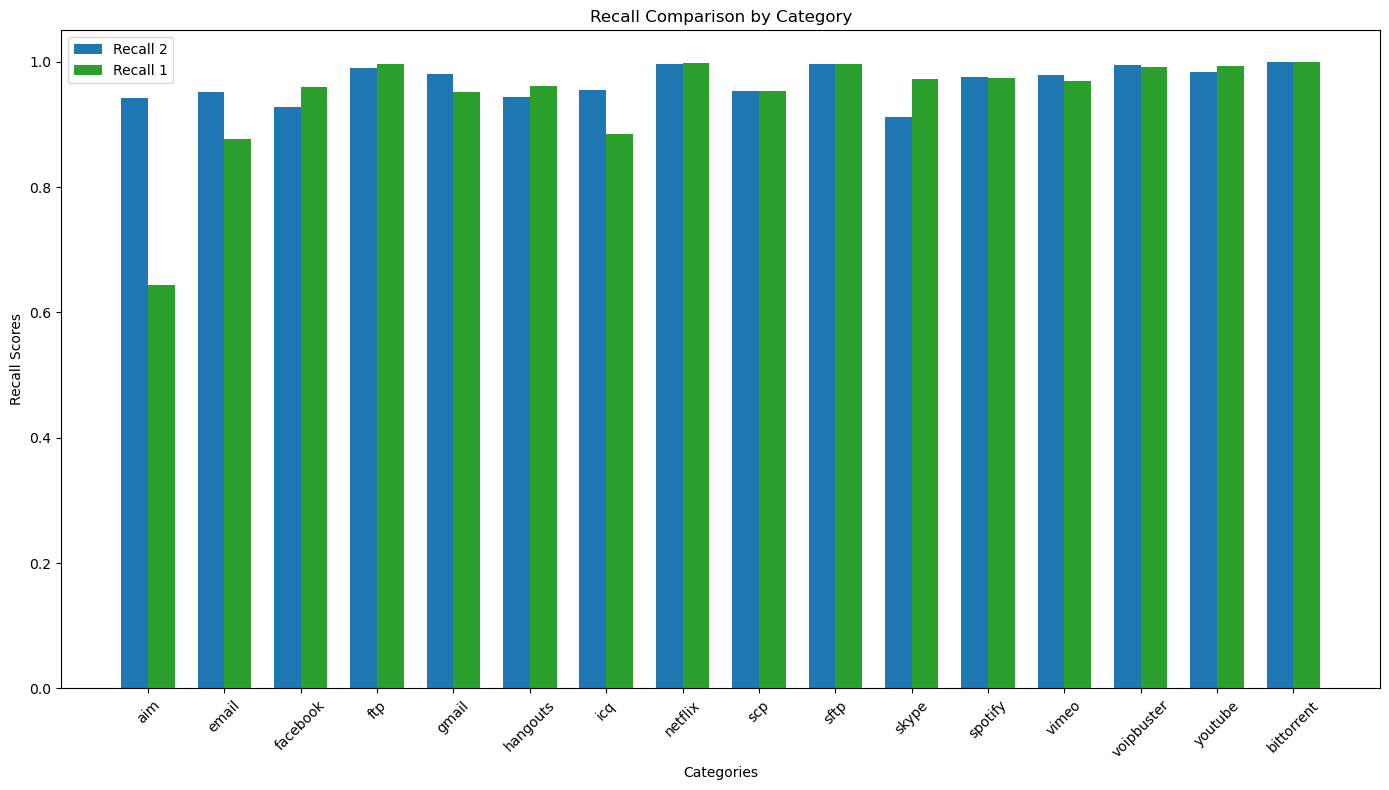

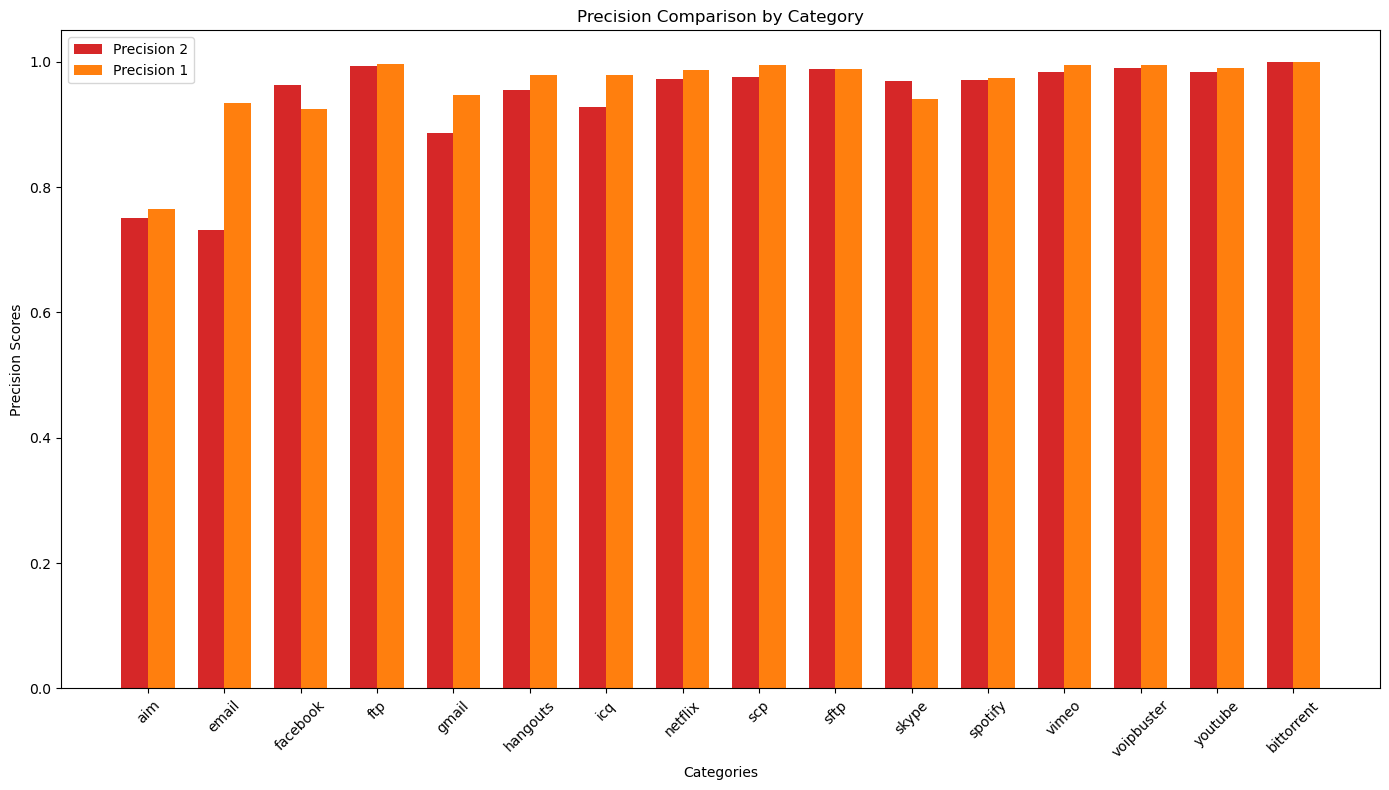

In [211]:
import matplotlib.pyplot as plt
import numpy as np

# Recall 和 Precision 的值
recall_1 = [0.6442308, 0.8773389, 0.9595397, 0.99562174, 0.9522472, 0.9604342,
            0.88517743, 0.9986807, 0.95393336, 0.99586535, 0.971863, 0.9732938,
            0.96930695, 0.9922541, 0.9925424, 1.0]

precision_1 = [0.7657143, 0.9346622, 0.92453504, 0.99562174, 0.94692737, 0.9789436,
               0.9792148, 0.9869622, 0.9940916, 0.9876977, 0.9409051, 0.9732938,
               0.99390864, 0.9945652, 0.9891892, 1.0]

recall_2 = [0.9423077, 0.95114344, 0.92724574, 0.9894921, 0.9803371, 0.9439776,
            0.954071, 0.9960422, 0.95251596, 0.99586535, 0.91127753, 0.97477746,
            0.97920793, 0.99535245, 0.9830508, 1.0]

precision_2 = [0.75095785, 0.73141485, 0.96224964, 0.9929701, 0.88578683, 0.9553508,
               0.9269777, 0.9729381, 0.97532654, 0.9876977, 0.969112, 0.9704579,
               0.98310137, 0.9899846, 0.9830508, 1.0]

# 调整x轴标签的顺序
categories = [
    "aim", "email", "facebook", "ftp", "gmail", "hangouts", "icq", "netflix",
    "scp", "sftp", "skype", "spotify", "vimeo", "voipbuster", "youtube", "bittorrent"
]

# 调整后的 Recall 和 Precision 值
adjusted_recall_1 = [recall_1[categories.index(cat)] for cat in categories]
adjusted_precision_1 = [precision_1[categories.index(cat)] for cat in categories]
adjusted_recall_2 = [recall_2[categories.index(cat)] for cat in categories]
adjusted_precision_2 = [precision_2[categories.index(cat)] for cat in categories]

x = np.arange(len(categories))  # 分类的数量
width = 0.35  # 条形图的宽度

# 绘制Recall条形图
fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width/2, adjusted_recall_2, width, label='Recall 2', color='#1f77b4')
bars2 = ax.bar(x + width/2, adjusted_recall_1, width, label='Recall 1', color='#2ca02c')

# 添加一些文本标签
ax.set_xlabel('Categories')
ax.set_ylabel('Recall Scores')
ax.set_title('Recall Comparison by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()

# 绘制Precision条形图
fig, ax = plt.subplots(figsize=(14, 8))
bars3 = ax.bar(x - width/2, adjusted_precision_2, width, label='Precision 2', color='#d62728')
bars4 = ax.bar(x + width/2, adjusted_precision_1, width, label='Precision 1', color='#ff7f0e')

ax.set_xlabel('Categories')
ax.set_ylabel('Precision Scores')
ax.set_title('Precision Comparison by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()


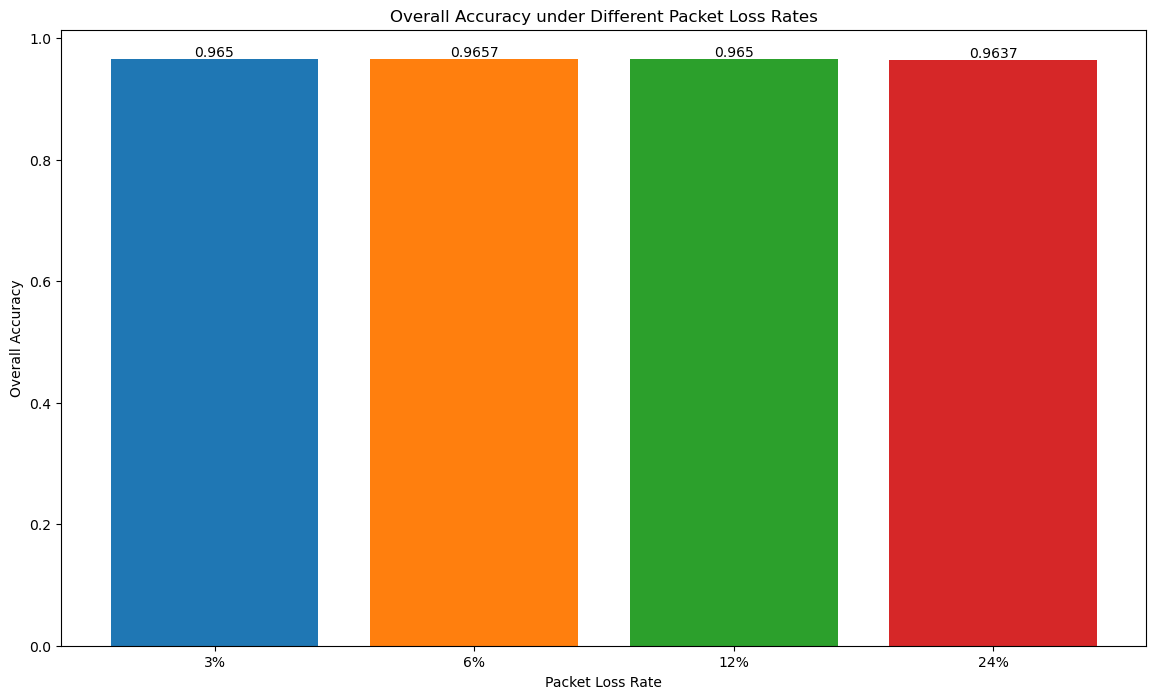

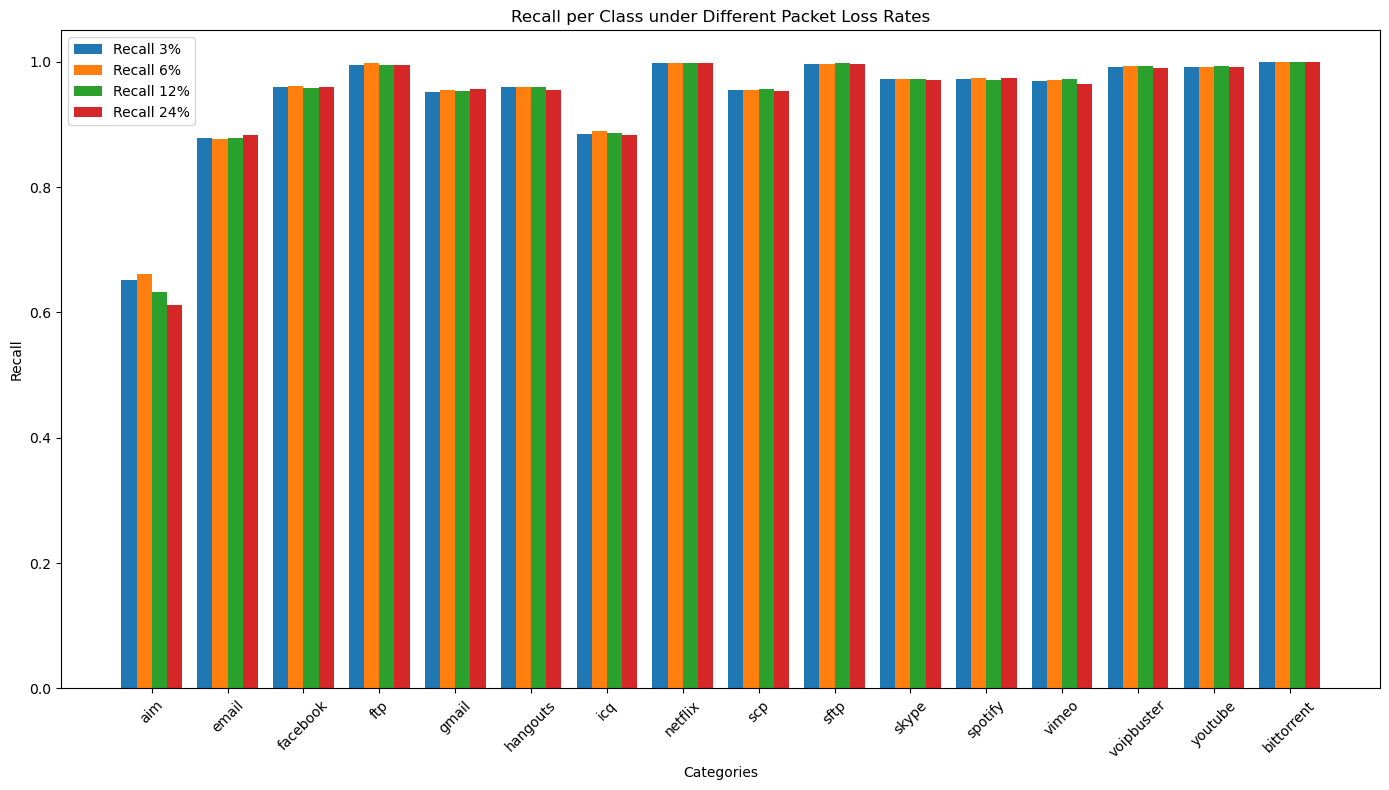

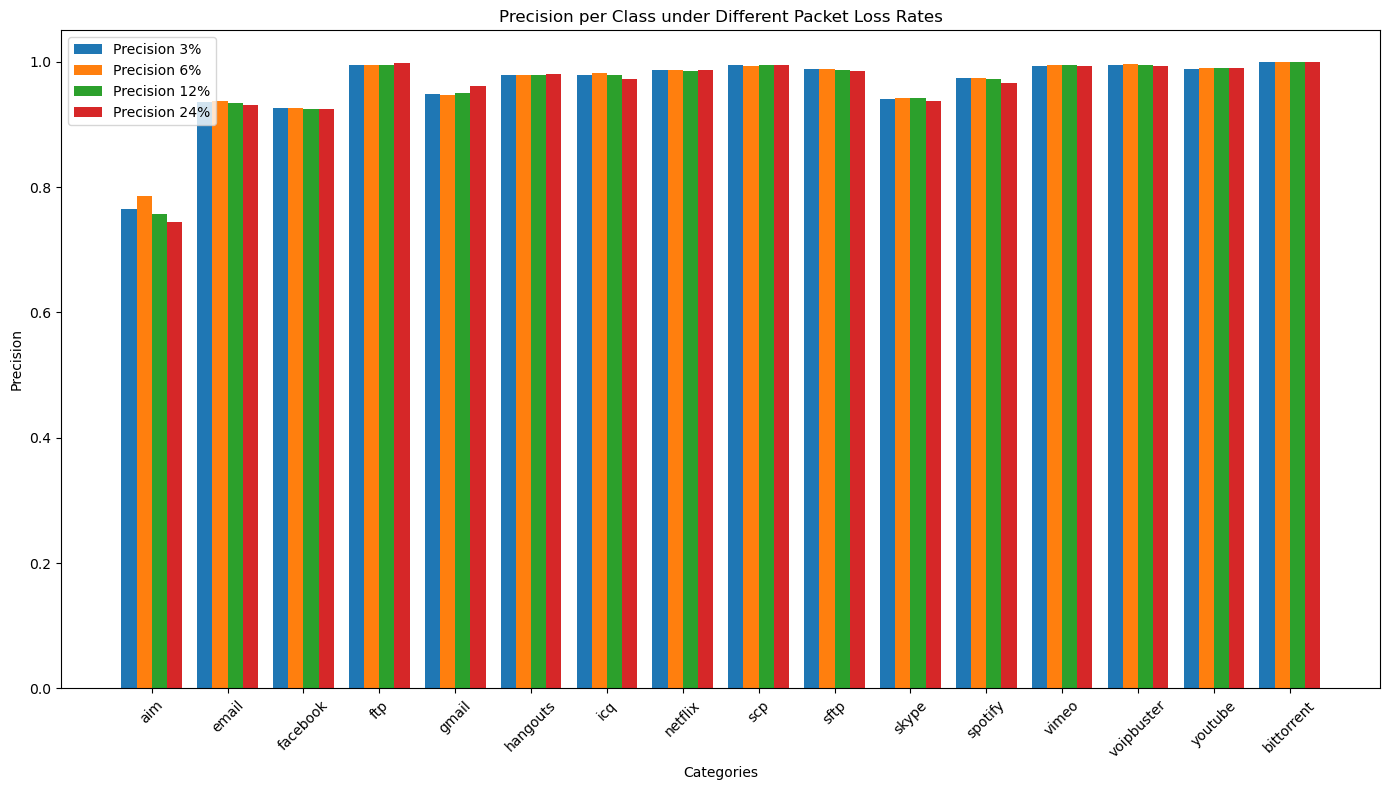

In [230]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
packet_loss_rates = ["3%", "6%", "12%", "24%"]
overall_accuracy = [0.9649859275867004, 0.9656903765690377, 0.9649805447470817, 0.9636529680365297]

recall_per_class = [
    [0.6519608, 0.87794435, 0.9596344, 0.9954669, 0.95156693, 0.95986986,
     0.8848614, 0.99863946, 0.9555717, 0.9957704, 0.9723459, 0.9721362,
     0.96938777, 0.9919485, 0.9922644, 1.0],
    [0.66137564, 0.87678766, 0.9609159, 0.9972015, 0.954955, 0.9591382,
     0.8893905, 0.9985856, 0.95475113, 0.99557245, 0.97253674, 0.9745223,
     0.97136796, 0.99264705, 0.99214286, 1.0],
    [0.6318681, 0.8777648, 0.9574378, 0.99496984, 0.953125, 0.9601128,
     0.8862559, 0.9984985, 0.95662653, 0.9973154, 0.9718564, 0.97118646,
     0.97194165, 0.9930495, 0.993865, 1.0],
    [0.6122449, 0.8827586, 0.95953757, 0.9954181, 0.95714283, 0.9548179,
     0.88300836, 0.99829644, 0.9526902, 0.996118, 0.970562, 0.9742063,
     0.96414346, 0.9896158, 0.9919355, 1.0]
]

precision_per_class = [
    [0.7643678, 0.9350057, 0.92544985, 0.9954669, 0.9488636, 0.9786214,
     0.9787736, 0.98655915, 0.9939394, 0.9880096, 0.9412432, 0.9736434,
     0.99372387, 0.99435025, 0.98878765, 1.0],
    [0.7861635, 0.93654525, 0.9258273, 0.9953445, 0.9464286, 0.9784009,
     0.98254365, 0.9874126, 0.9937206, 0.9880728, 0.9416842, 0.9745223,
     0.9945711, 0.99590164, 0.9893162, 1.0],
    [0.7565789, 0.9343247, 0.92508143, 0.99496984, 0.95015574, 0.9790468,
     0.9790576, 0.9851852, 0.99415696, 0.98606503, 0.9419419, 0.9728353,
     0.9942595, 0.99391305, 0.989313, 1.0],
    [0.74380165, 0.9302326, 0.9252206, 0.9977038, 0.9605735, 0.97965944,
     0.9723926, 0.986532, 0.99419165, 0.9846508, 0.9371232, 0.96653545,
     0.99316007, 0.9937435, 0.990161, 1.0]
]

categories = ["aim", "email", "facebook", "ftp", "gmail", "hangouts", "icq", "netflix",
              "scp", "sftp", "skype", "spotify", "vimeo", "voipbuster", "youtube", "bittorrent"]

# 绘制总体准确率条形图
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(packet_loss_rates, overall_accuracy, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])


ax.set_xlabel('Packet Loss Rate')
ax.set_ylabel('Overall Accuracy')
ax.set_title('Overall Accuracy under Different Packet Loss Rates')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()


fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(categories))
width = 0.2

bars1 = ax.bar(x - 1.5*width, recall_per_class[0], width, label='Recall 3%', color='#1f77b4')
bars2 = ax.bar(x - 0.5*width, recall_per_class[1], width, label='Recall 6%', color='#ff7f0e')
bars3 = ax.bar(x + 0.5*width, recall_per_class[2], width, label='Recall 12%', color='#2ca02c')
bars4 = ax.bar(x + 1.5*width, recall_per_class[3], width, label='Recall 24%', color='#d62728')

ax.set_xlabel('Categories')
ax.set_ylabel('Recall')
ax.set_title('Recall per Class under Different Packet Loss Rates')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - 1.5*width, precision_per_class[0], width, label='Precision 3%', color='#1f77b4')
bars2 = ax.bar(x - 0.5*width, precision_per_class[1], width, label='Precision 6%', color='#ff7f0e')
bars3 = ax.bar(x + 0.5*width, precision_per_class[2], width, label='Precision 12%', color='#2ca02c')
bars4 = ax.bar(x + 1.5*width, precision_per_class[3], width, label='Precision 24%', color='#d62728')

ax.set_xlabel('Categories')
ax.set_ylabel('Precision')
ax.set_title('Precision per Class under Different Packet Loss Rates')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()


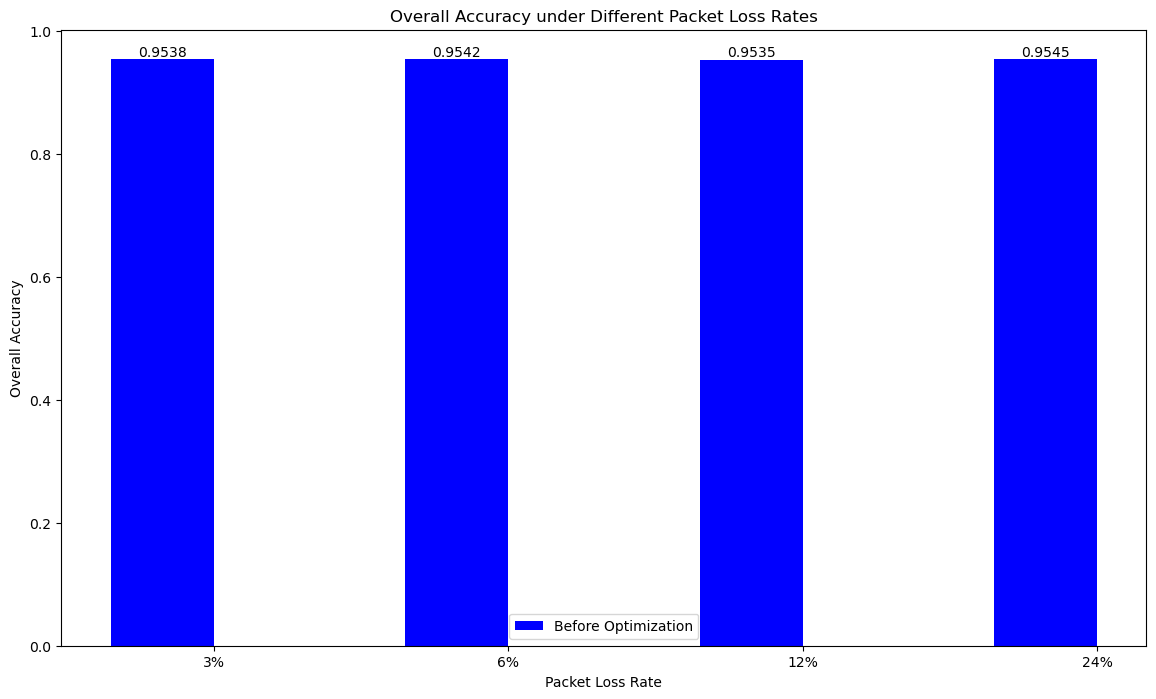

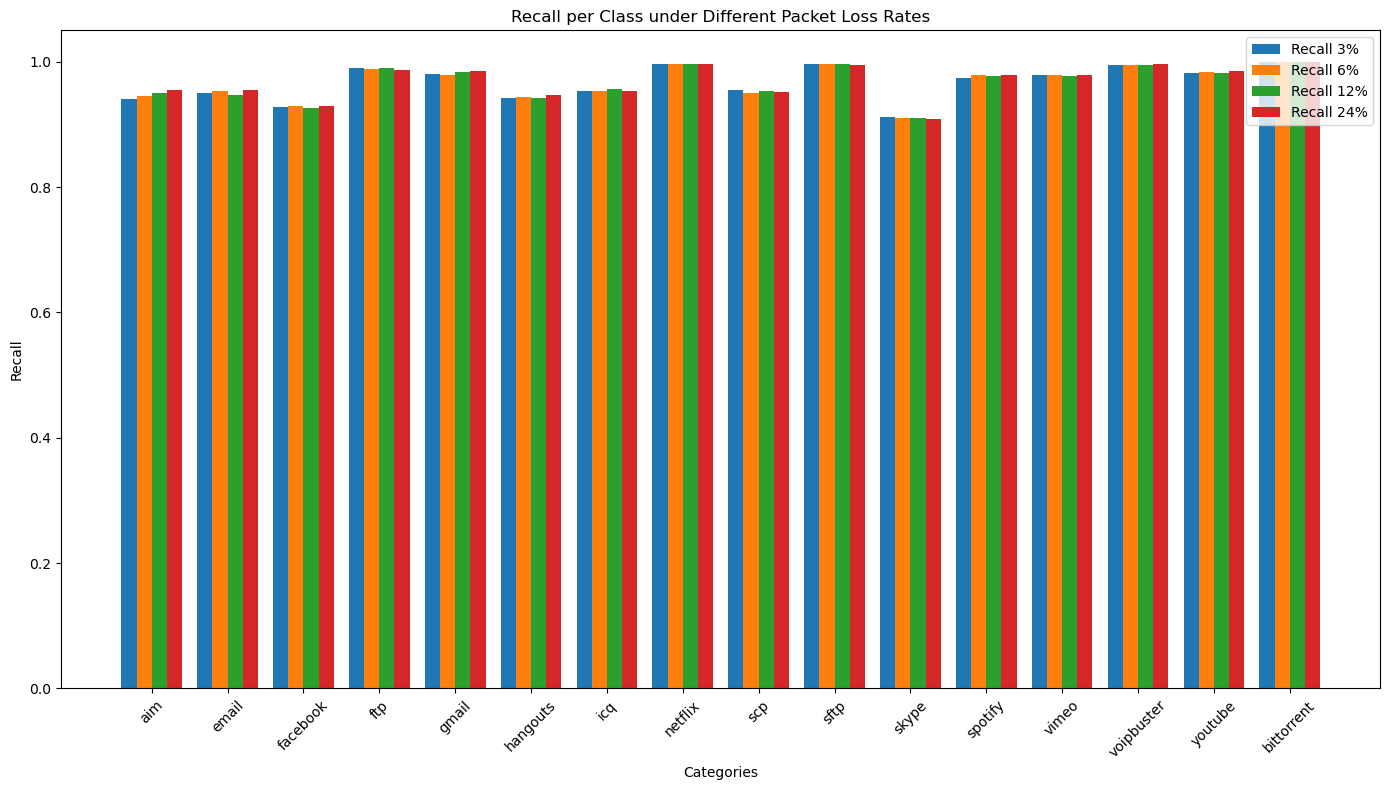

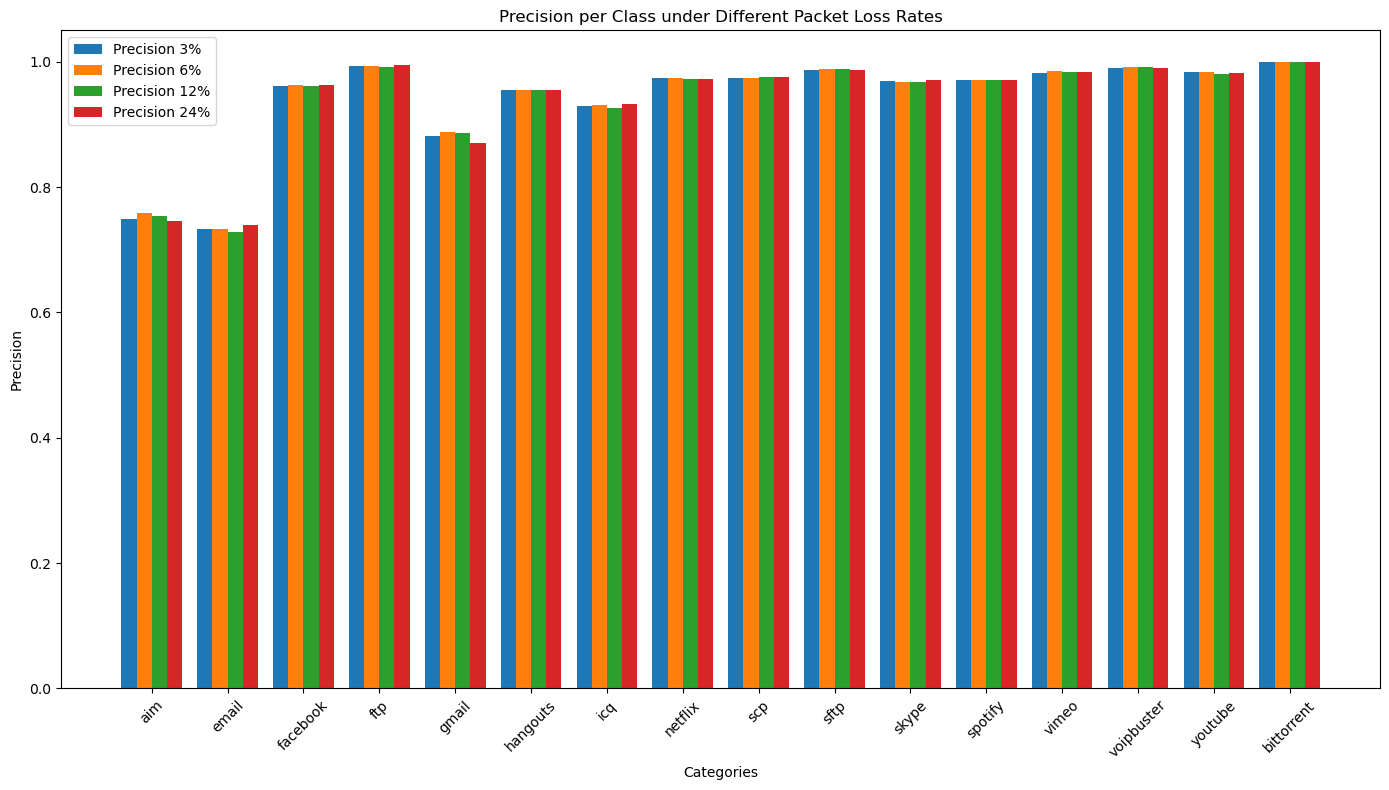

In [240]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
packet_loss_rates = ["3%", "6%", "12%", "24%"]
overall_accuracy_before = [0.9538234031388637, 0.9542210189515137, 0.953517720054685, 0.9545205479452055]

recall_per_class_before = [
    [0.9408867, 0.9496788, 0.9273356, 0.9891599, 0.97959185, 0.9424253,
     0.9531915, 0.9958848, 0.9541151, 0.9957395, 0.91157895, 0.9739663,
     0.9794872, 0.9952229, 0.9825175, 1.0],
    [0.945, 0.95279914, 0.92882705, 0.9888372, 0.97935104, 0.94429904,
     0.95302016, 0.9958449, 0.95049506, 0.9956085, 0.9105124, 0.9794953,
     0.97894734, 0.9950495, 0.9841499, 1.0],
    [0.9508197, 0.94649225, 0.9268395, 0.98913044, 0.98392284, 0.94220805,
     0.95704055, 0.99558175, 0.95307446, 0.9958876, 0.9108707, 0.9767442,
     0.9775533, 0.99471366, 0.98232126, 1.0],
    [0.955414, 0.9546703, 0.92898554, 0.9873272, 0.98490566, 0.94727015,
     0.9527778, 0.9965338, 0.95158285, 0.9953235, 0.908142, 0.97843134,
     0.97938144, 0.9969819, 0.98486197, 1.0]
]

precision_per_class_before = [
    [0.7490196, 0.7324525, 0.96095616, 0.99364793, 0.88188976, 0.95479405,
     0.9294606, 0.97449666, 0.97470236, 0.9873265, 0.96892095, 0.9709924,
     0.98251027, 0.98970705, 0.983205, 1.0],
    [0.7590361, 0.7337278, 0.96210873, 0.993458, 0.88770056, 0.95537066,
     0.930131, 0.9742547, 0.9742389, 0.98755443, 0.96827835, 0.9703125,
     0.9851695, 0.9909614, 0.9827338, 1.0],
    [0.7532467, 0.72893775, 0.96057194, 0.99207133, 0.8869565, 0.9555376,
     0.926097, 0.97266185, 0.9759735, 0.9884354, 0.9677066, 0.97029704,
     0.98306996, 0.99122036, 0.9808135, 1.0],
    [0.74626863, 0.7393617, 0.9629444, 0.9941995, 0.87, 0.9543959,
     0.9320652, 0.9729272, 0.97612226, 0.9861004, 0.97036326, 0.97081715,
     0.98318243, 0.99000996, 0.98136646, 1.0]
]

categories = ["aim", "email", "facebook", "ftp", "gmail", "hangouts", "icq", "netflix",
              "scp", "sftp", "skype", "spotify", "vimeo", "voipbuster", "youtube", "bittorrent"]

# 绘制总体准确率条形图
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(packet_loss_rates))
width = 0.35

bars1 = ax.bar(x - width/2, overall_accuracy_before, width, label='Before Optimization', color='b')

ax.set_xlabel('Packet Loss Rate')
ax.set_ylabel('Overall Accuracy')
ax.set_title('Overall Accuracy under Different Packet Loss Rates')
ax.set_xticks(x)
ax.set_xticklabels(packet_loss_rates)
ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()

# 绘制每个类别的召回率条形图
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(categories))
width = 0.2

bars1 = ax.bar(x - 1.5*width, recall_per_class_before[0], width, label='Recall 3%', color='#1f77b4')
bars2 = ax.bar(x - 0.5*width, recall_per_class_before[1], width, label='Recall 6%', color='#ff7f0e')
bars3 = ax.bar(x + 0.5*width, recall_per_class_before[2], width, label='Recall 12%', color='#2ca02c')
bars4 = ax.bar(x + 1.5*width, recall_per_class_before[3], width, label='Recall 24%', color='#d62728')

ax.set_xlabel('Categories')
ax.set_ylabel('Recall')
ax.set_title('Recall per Class under Different Packet Loss Rates')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()

# 绘制每个类别的精确率条形图
fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - 1.5*width, precision_per_class_before[0], width, label='Precision 3%', color='#1f77b4')
bars2 = ax.bar(x - 0.5*width, precision_per_class_before[1], width, label='Precision 6%', color='#ff7f0e')
bars3 = ax.bar(x + 0.5*width, precision_per_class_before[2], width, label='Precision 12%', color='#2ca02c')
bars4 = ax.bar(x + 1.5*width, precision_per_class_before[3], width, label='Precision 24%', color='#d62728')

ax.set_xlabel('Categories')
ax.set_ylabel('Precision')
ax.set_title('Precision per Class under Different Packet Loss Rates')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()


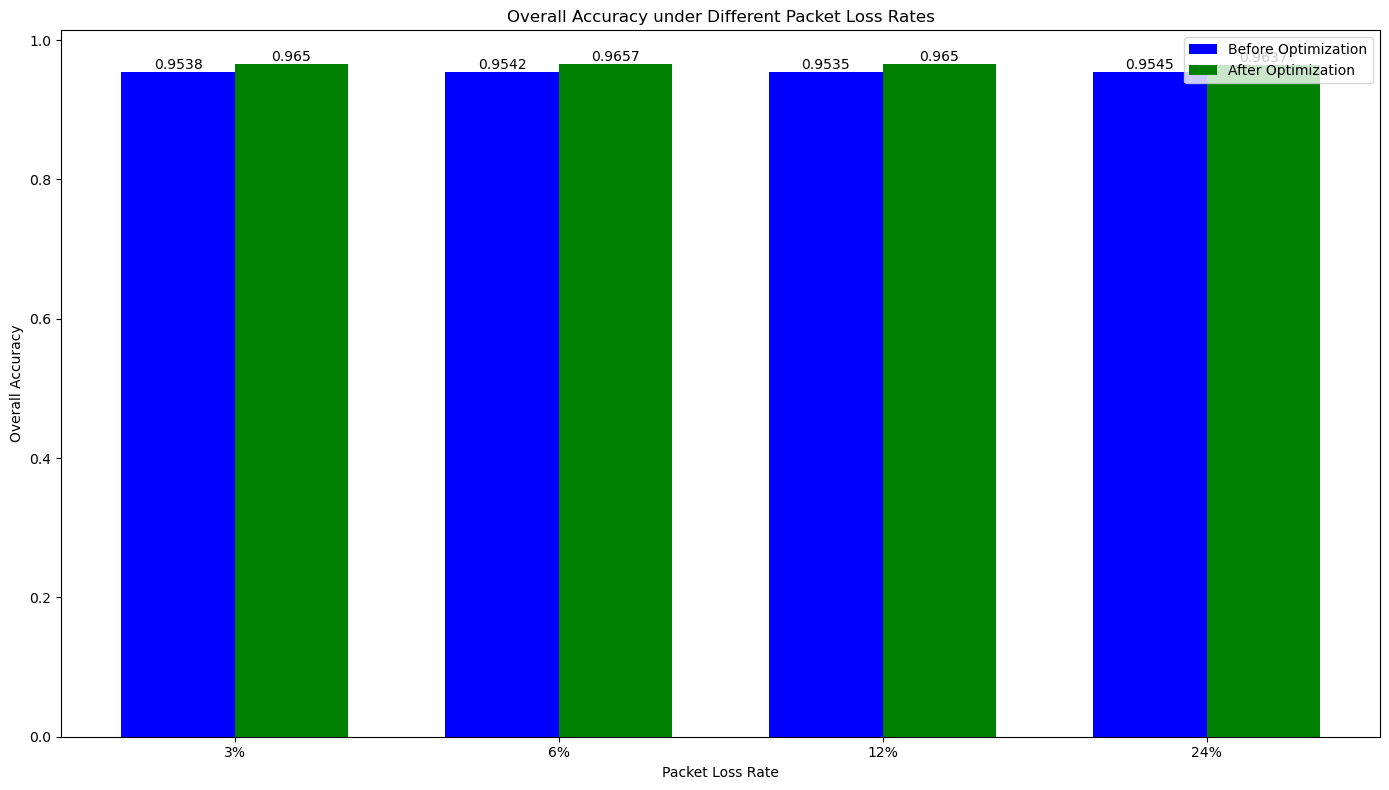

In [241]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
packet_loss_rates = ["3%", "6%", "12%", "24%"]
overall_accuracy_before = [0.9538234031388637, 0.9542210189515137, 0.953517720054685, 0.9545205479452055]
overall_accuracy_after = [0.9649859275867004, 0.9656903765690377, 0.9649805447470817, 0.9636529680365297]

# 绘制总体准确率条形图
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(packet_loss_rates))
width = 0.35

bars1 = ax.bar(x - width/2, overall_accuracy_before, width, label='Before Optimization', color='b')
bars2 = ax.bar(x + width/2, overall_accuracy_after, width, label='After Optimization', color='g')

# 添加文本标签
ax.set_xlabel('Packet Loss Rate')
ax.set_ylabel('Overall Accuracy')
ax.set_title('Overall Accuracy under Different Packet Loss Rates')
ax.set_xticks(x)
ax.set_xticklabels(packet_loss_rates)
ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()


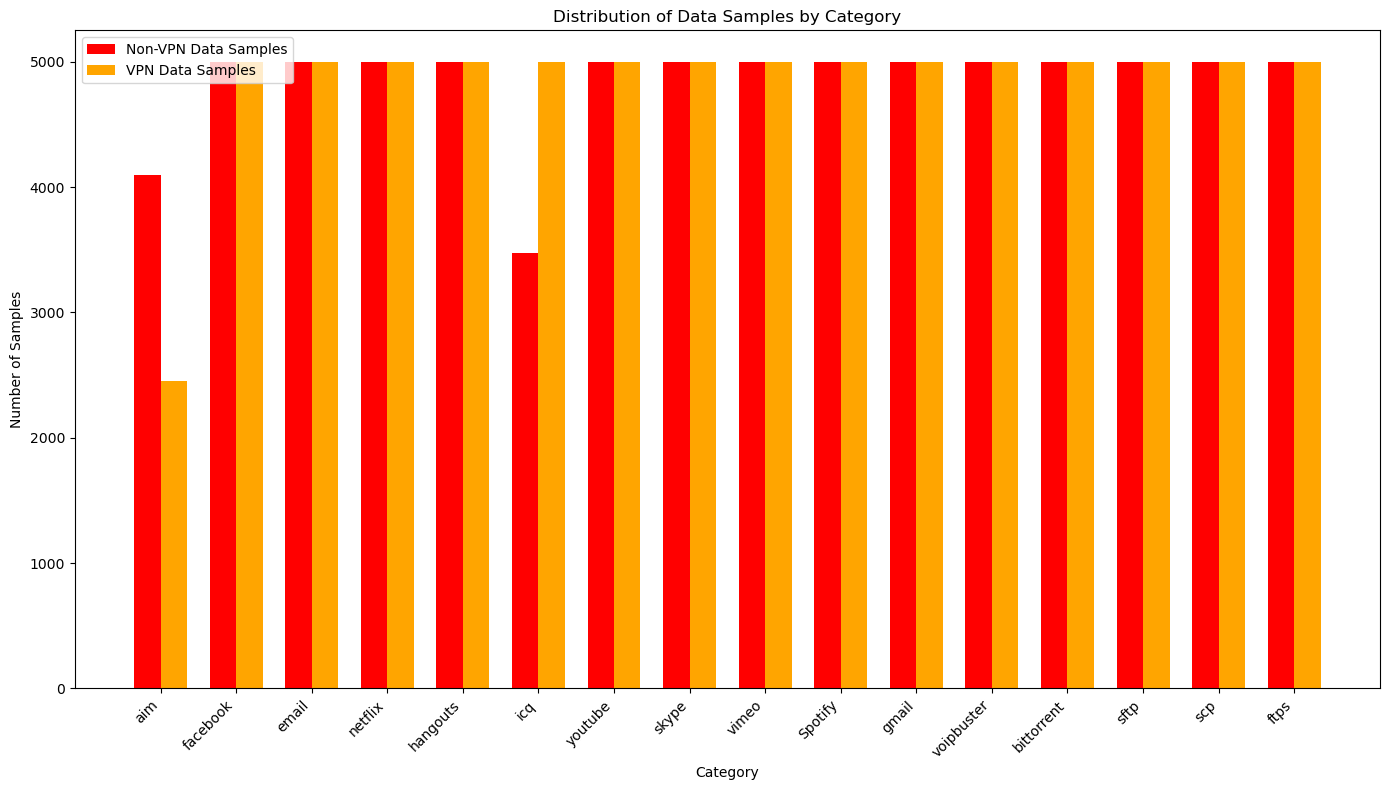

In [258]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
categories = ["aim", "facebook", "email", "netflix", "hangouts", "icq", "youtube", "skype", "vimeo", "Spotify", "gmail", "voipbuster", "bittorrent", "sftp", "scp", "ftps"]
non_vpn_counts = [4099, 5000, 5000, 5000, 5000, 3476, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
vpn_counts = [2455, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


fig, ax = plt.subplots(figsize=(14, 8))


width = 0.35


x = np.arange(len(categories))


bars1 = ax.bar(x - width/2, non_vpn_counts, width, label='Non-VPN Data Samples', color='r')
bars2 = ax.bar(x + width/2, vpn_counts, width, label='VPN Data Samples', color='orange')

# 添加文本标签
ax.set_xlabel('Category')
ax.set_ylabel('Number of Samples')
ax.set_title('Distribution of Data Samples by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


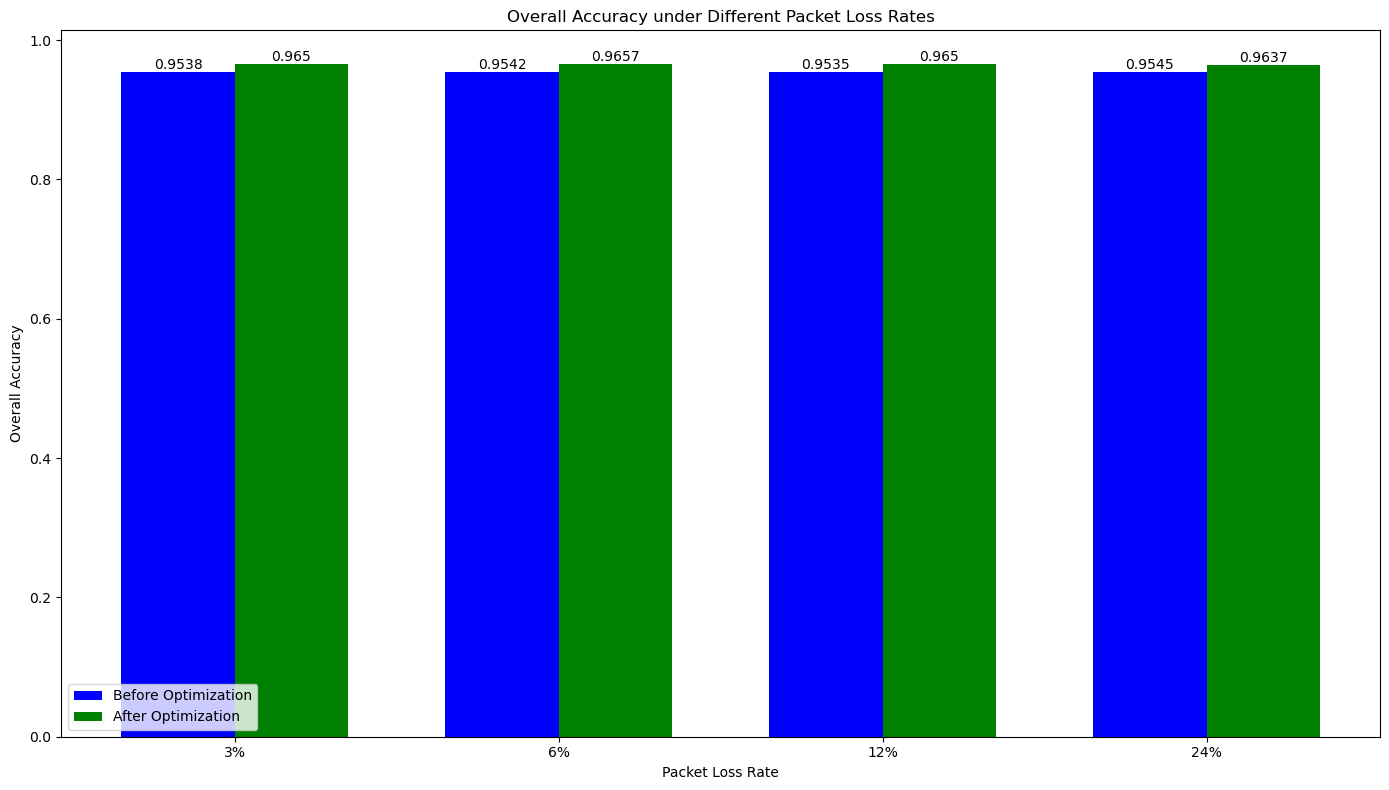

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
packet_loss_rates = ["3%", "6%", "12%", "24%"]
overall_accuracy_before = [0.9538234031388637, 0.9542210189515137, 0.953517720054685, 0.9545205479452055]
overall_accuracy_after = [0.9649859275867004, 0.9656903765690377, 0.9649805447470817, 0.9636529680365297]


fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(packet_loss_rates))
width = 0.35

bars1 = ax.bar(x - width/2, overall_accuracy_before, width, label='Before Optimization', color='b')
bars2 = ax.bar(x + width/2, overall_accuracy_after, width, label='After Optimization', color='g')

# 添加文本标签
ax.set_xlabel('Packet Loss Rate')
ax.set_ylabel('Overall Accuracy')
ax.set_title('Overall Accuracy under Different Packet Loss Rates')
ax.set_xticks(x)
ax.set_xticklabels(packet_loss_rates)
ax.legend(loc='lower left')  

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()
